Notebook 7 : Model Validation & Forecast Analysis
* Goal: To rigorously backtest our Prophet model's predictive accuracy and analyze the components of our final 20-year forecast.

Block 1: Imports

We'll import libraries for data, modeling, and crucially, performance metrics from sklearn.

In [78]:
import pandas as pd
from prophet import Prophet
from prophet.serialize import model_from_json
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_dark"
print("Libraries for model validation imported.")

Libraries for model validation imported.


Block 2: Load Data for Backtesting

We need the original, clean data that we used to train the model, which is global_demand_ts.csv.

In [79]:
# Load the main dataset used for modeling
df_global = pd.read_csv('global_demand_ts.csv')

# Prepare the data for Prophet (filter year 0, rename cols)
df_prophet = df_global[df_global['Year'] > 1950].copy()
df_prophet['ds'] = pd.to_datetime(df_prophet['Year'], format='%Y')
df_prophet = df_prophet.rename(columns={'Total Thermal Capacity, MWt': 'y'})[['ds', 'y']]

print("Loaded and prepared global demand data for backtesting.")

Loaded and prepared global demand data for backtesting.


Block 3: Perform Historical Train/Test Split

For time-series, we can't do a random split. We must split by time. We'll train our model on all data up to 2015 and test it on the period 2015-present.

In [80]:
# Define the split point
split_date = '2015-01-01'

# Create training and testing sets
train_data = df_prophet[df_prophet['ds'] < split_date]
test_data = df_prophet[df_prophet['ds'] >= split_date]

print(f"Training data: {train_data.shape[0]} years (up to 2015)")
print(f"Testing data: {test_data.shape[0]} years (2015-present)")

Training data: 46 years (up to 2015)
Testing data: 10 years (2015-present)


Block 4: Train Backtest Model and Predict

We will initialize a new Prophet model and train it only on our train_data.

In [83]:
# Initialize a new model for the backtest
backtest_model = Prophet(yearly_seasonality=True)

# Fit it *only* on the training data
backtest_model.fit(train_data)

# Create a 'future' DataFrame that covers the test period
# We ask it to predict the number of years in our test set
# Changed freq from 'Y' (Year End) to 'YS' (Year Start) to match df_prophet date format.
future_backtest = backtest_model.make_future_dataframe(periods=len(test_data), freq='YS')

# Make the prediction
forecast_backtest = backtest_model.predict(future_backtest)

print("Backtest model trained and predictions generated.")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Backtest model trained and predictions generated.


Block 5: Evaluate Performance & Plot Backtest

Now we'll compare the model's predictions (yhat) to the actual data (y) for the test period and calculate our error metrics.

In [85]:
# 1. Isolate the predictions for the test period
# We merge the forecast with the actual test data
results = pd.merge(
    test_data,
    forecast_backtest[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    on='ds'
)

# 2. Calculate metrics
mae = mean_absolute_error(results['y'], results['yhat'])
# Calculate MSE first, then take the square root for RMSE
mse = mean_squared_error(results['y'], results['yhat'])
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(results['y'], results['yhat'])

print("--- Backtest Performance Metrics (2015-Present) ---")
print(f"Mean Absolute Error (MAE):     {mae:,.0f} MWt")
print(f"Root Mean Squared Error (RMSE): {rmse:,.0f} MWt")
print(f"Mean Absolute Pct Error (MAPE): {mape:.2%}")
print("--------------------------------------------------")

# 3. Plot the backtest results
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=train_data['ds'], y=train_data['y'],
    mode='markers', name='Training Data'
))
fig.add_trace(go.Scatter(
    x=results['ds'], y=results['y'],
    mode='markers', name='Actual Test Data', marker=dict(color='white', size=6)
))
fig.add_trace(go.Scatter(
    x=results['ds'], y=results['yhat'],
    mode='lines', name='Model Prediction (yhat)', line=dict(color='cyan', dash='dash')
))
fig.update_layout(
    title='Model Backtest: Actuals vs. Prediction (2015-Present)',
    xaxis_title='Year', yaxis_title='Total Thermal Capacity (MWt)'
)
fig.show()

--- Backtest Performance Metrics (2015-Present) ---
Mean Absolute Error (MAE):     46,795 MWt
Root Mean Squared Error (RMSE): 53,289 MWt
Mean Absolute Pct Error (MAPE): 4.32%
--------------------------------------------------


Block 6: Analyze Final Forecast Components

Now that we've validated the model's method, let's load our final model (from Notebook 6) and analyze its components to understand what it learned.

Loaded final model and forecast from Notebook 6.
Generating forecast component plot...

--- Notebook 7 complete. ---


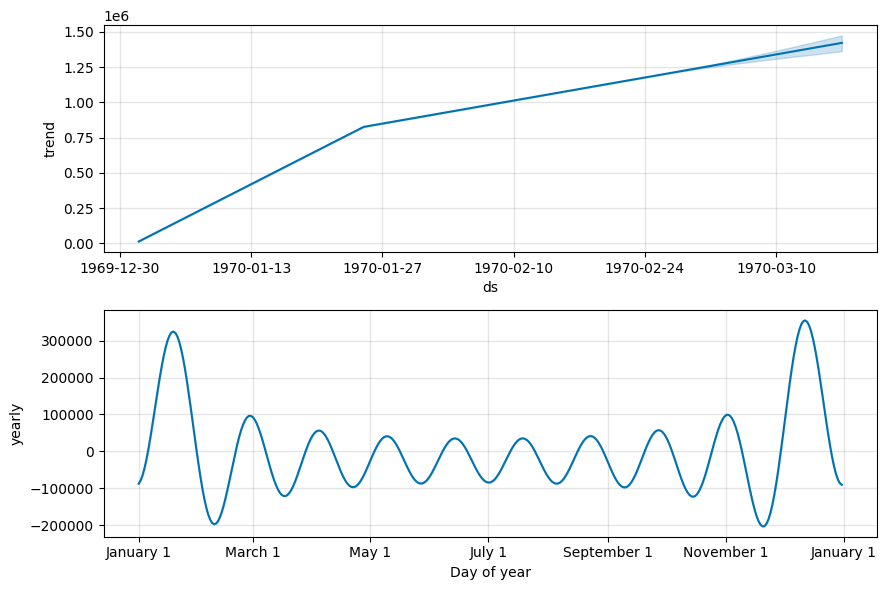

In [86]:
# Load the final model and forecast from Notebook 6
with open('prophet_model.json', 'r') as f:
    final_model = model_from_json(json.load(f))

df_final_forecast = pd.read_csv('forecast_data.csv')

print("Loaded final model and forecast from Notebook 6.")

# Use Prophet's built-in plotting to see the components
# This shows the underlying trend and any seasonal patterns
print("Generating forecast component plot...")
fig_components = final_model.plot_components(df_final_forecast)
fig_components.show()

print("\n--- Notebook 7 complete. ---")